In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../dataset.csv')
comments = data.comment_text.values
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [3]:
# Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_comments = tokenizer(comments.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

In [6]:
# Split the dataset into training and validation sets first
train_comments, val_comments, train_labels, val_labels = train_test_split(comments, labels, test_size=0.1, random_state=42)

# Tokenize the training set
train_encodings = tokenizer(list(train_comments), truncation=True, padding=True, max_length=128)
train_labels = torch.tensor(train_labels)

# Tokenize the validation set
val_encodings = tokenizer(list(val_comments), truncation=True, padding=True, max_length=128)
val_labels = torch.tensor(val_labels)

# Convert to PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), 
                              torch.tensor(train_encodings['attention_mask']), 
                              train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), 
                            torch.tensor(val_encodings['attention_mask']), 
                            val_labels)


In [9]:
# Define DataLoaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)  # Move your model to the selected device

Using device: mps


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
from torch.optim import AdamW

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(4): 
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for batch in train_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.float())
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
    
    average_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{4}, Average Loss: {average_loss:.4f}")

Using device: mps
Epoch 1/4, Average Loss: 0.0482
Epoch 2/4, Average Loss: 0.0385
Epoch 3/4, Average Loss: 0.0336
Epoch 4/4, Average Loss: 0.0293


In [19]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_state_dict.pth')

# Optionally, save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state_dict.pth')

In [ ]:
# Assuming the model and optimizer have been defined with the same architecture
model.load_state_dict(torch.load('model_state_dict.pth'))

# If you also saved and now wish to load the optimizer state
optimizer.load_state_dict(torch.load('optimizer_state_dict.pth'))

# Move model back to the appropriate device after loading weights
model.to(device)


In [21]:
model.eval()
predictions, true_labels = [], []

# Ensure 'device' is defined as MPS if available, or CPU as a fallback
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for batch in val_loader:
    # Move tensors to the appropriate device (MPS or CPU)
    b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    
    # Move logits to CPU for numpy conversion, if needed for further processing
    predictions.append(logits.detach().cpu().numpy())
    true_labels.append(b_labels.detach().cpu().numpy())


In [23]:
from sklearn.metrics import classification_report
import numpy as np

# Convert the predictions and true labels from lists of arrays to single arrays
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Assuming predictions are the raw logits from your model
# Apply sigmoid to convert logits to probabilities
probabilities = torch.sigmoid(torch.from_numpy(predictions)).numpy()

# Apply a threshold to these probabilities to get predicted labels
threshold = 0.5
predicted_labels = (probabilities > threshold).astype(int)

# Now, you can use classification_report
print(classification_report(true_labels, predicted_labels, zero_division=0))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     92309
           1       0.80      0.72      0.76      3439

    accuracy                           0.98     95748
   macro avg       0.89      0.86      0.87     95748
weighted avg       0.98      0.98      0.98     95748



In [26]:
model.eval()  # Set the model to evaluation mode
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

threshold = 0.5  # Common choice for a threshold
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        # Apply sigmoid to convert outputs to probabilities
        probabilities = torch.sigmoid(outputs.logits)
        
        # Apply threshold to determine predicted labels
        predicted_labels = (probabilities >= threshold).int()
        
        # Update total_correct by comparing with true labels
        total_correct += (predicted_labels == b_labels.int()).all(dim=1).sum().item()
        total_samples += b_labels.size(0)

# Calculate multi-label accuracy
accuracy = total_correct / total_samples
print(f'Multi-Label Classification Accuracy: {accuracy:.4f}')


Multi-Label Classification Accuracy: 0.9239


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# Assuming `model` is your trained model and `val_loader` is your DataLoader for validation data
model.eval()  # Set the model to evaluation mode
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [28]:
# Storage for model outputs
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = torch.sigmoid(outputs.logits)  # Assuming sigmoid activation for multi-label classification
        all_labels.append(b_labels)
        all_preds.append(logits)

In [29]:
# Concatenate all the outputs and labels
all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

In [30]:
# Calculate precision-recall and ROC metrics for each class
precision = dict()
recall = dict()
average_precision = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

In [31]:
# Plotting both Precision-Recall Curve and ROC Curve for each class
for i in range(all_labels.shape[1]):  # Assuming your output has one column per class
    precision[i], recall[i], _ = precision_recall_curve(all_labels[:, i], all_preds[:, i])
    average_precision[i] = roc_auc_score(all_labels[:, i], all_preds[:, i], average="macro")
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_preds[:, i])


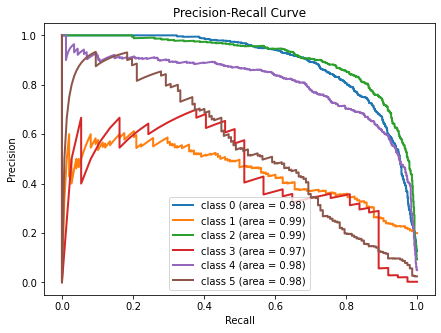

In [32]:
# Plot Precision-Recall Curve
plt.figure(figsize=(7, 5))
for i in range(all_labels.shape[1]):
    plt.plot(recall[i], precision[i], lw=2, label='class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


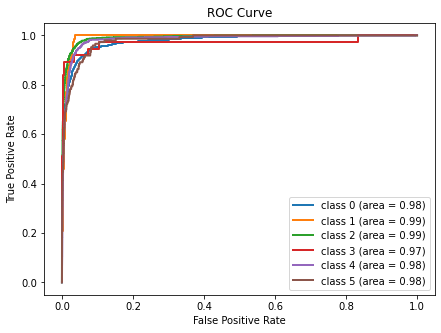

In [34]:
# Plot ROC Curve
plt.figure(figsize=(7, 5))
for i in range(all_labels.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label='class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [35]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Assuming your model has been trained and you have a DataLoader 'val_loader' for validation data
# Also assuming 'device' is defined as before to use MPS if available

model.eval()  # Set the model to evaluation mode

# Prepare lists to store true labels and predictions
true_labels = []
predictions = []

with torch.no_grad():
    for batch in val_loader:
        # Add batch to GPU or MPS
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Predict
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Convert output probabilities to predicted class (0 or 1)
        preds = torch.sigmoid(outputs.logits).to('cpu').numpy()
        preds = np.where(preds > 0.5, 1, 0)

        # Append batch predictions and true labels
        predictions.append(preds)
        true_labels.append(b_labels.to('cpu').numpy())

# Flatten the lists
predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)

# Calculate the classification report
report = classification_report(true_labels, predictions, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

print(report)

               precision    recall  f1-score   support

        toxic       0.80      0.80      0.80      1480
 severe_toxic       0.59      0.16      0.25       148
      obscene       0.88      0.75      0.81       836
       threat       0.38      0.57      0.45        37
       insult       0.78      0.70      0.74       791
identity_hate       0.63      0.45      0.53       147

    micro avg       0.80      0.72      0.76      3439
    macro avg       0.68      0.57      0.60      3439
 weighted avg       0.80      0.72      0.75      3439
  samples avg       0.07      0.07      0.06      3439



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
from sklearn.metrics import accuracy_score

model.eval()  # Make sure the model is in eval mode

all_preds = []
all_true = []

with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        preds = (torch.sigmoid(outputs.logits) > 0.5).int()  # Threshold probabilities for multi-label
        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_true.extend(b_labels.cpu().numpy())  # Store true labels

# Compute accuracy for multi-label task
# Note: This calculates the "subset accuracy" for multi-label tasks.
# It's a strict metric that requires all labels for each sample to be correct.
accuracy = accuracy_score(all_true, all_preds)
print(f"Multi-Label Subset Accuracy: {accuracy:.4f}")

Multi-Label Subset Accuracy: 0.9239
